In [1]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_feature_matrices, load_metadata
from scripts.features import save_ctms, save_sequences
from utils.frobenius import create_frobenius_adjacency_matrix
from models.graph import create_movie_nodes, MovieGraph

In [2]:
save_sequences("../data/midis", "../data/sequences")
save_ctms("../data/midis", "../data/ctms")

Processing MIDIs: 6it [00:00, 20.12it/s]/home/jyanes/project-02807/.venv/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing MIDIs: 91it [00:05, 15.34it/s]
2025-11-08 12:28:58.398 | SUCCESS  | scripts.features:save_sequences:127 - Processed 91 MIDI files -> saved to ../data/sequences/sequences_summary.csv
Processing MIDIs: 91it [00:05, 15.43it/s]
2025-11-08 12:29:04.301 | SUCCESS  | scripts.features:save_ctms:91 - Processed 91 MIDI files -> saved to ../data/ctms/summary.csv


In [3]:
matrices_df = load_feature_matrices("../data/ctms")
metadata_df = load_metadata("../data/metadata/movies_metadata.csv")

# Normalize each CTM so the total sum is 1
def normalize_rowwise(M: np.ndarray) -> np.ndarray:
    M = M.astype(np.float64)          # convert to float
    row_sums = M.sum(axis=1, keepdims=True)
    return np.divide(M, row_sums, out=np.zeros_like(M), where=row_sums!=0)

matrices_df['matrix'] = matrices_df['matrix'].apply(normalize_rowwise)

metadata_df = metadata_df.loc[matrices_df.index] # align matrices and metadata

Loading matrices: 91it [00:00, 4297.15it/s]
2025-11-08 12:29:04.335 | SUCCESS  | utils.load:load_feature_matrices:45 - Loaded 91 matrices from ../data/ctms


In [4]:
ctms_list = matrices_df['matrix'].tolist()
frob_matrix = create_frobenius_adjacency_matrix(ctms_list)

Calculating Frobenius graph: 100%|██████████| 91/91 [00:21<00:00,  4.16it/s]


In [5]:
print(metadata_df.head())
nodes = create_movie_nodes(metadata_df)
graph = MovieGraph(nodes, frob_matrix)

                                     title     released  \
id                                                        
tt0026138            Bride of Frankenstein  06 May 1935   
tt0029583  Snow White and the Seven Dwarfs  04 Feb 1938   
tt0032138                 The Wizard of Oz  25 Aug 1939   
tt0040076           Adventures of Don Juan  29 Jan 1949   
tt0045152              Singin' in the Rain  10 Apr 1952   

                                                director  imdbrating  \
id                                                                     
tt0026138                                    James Whale         7.8   
tt0029583  William Cottrell, David Hand, Wilfred Jackson         7.6   
tt0032138    Victor Fleming, George Cukor, Norman Taurog         8.1   
tt0040076                                Vincent Sherman         7.0   
tt0045152                      Stanley Donen, Gene Kelly         8.3   

                                                     ratings  \
id               

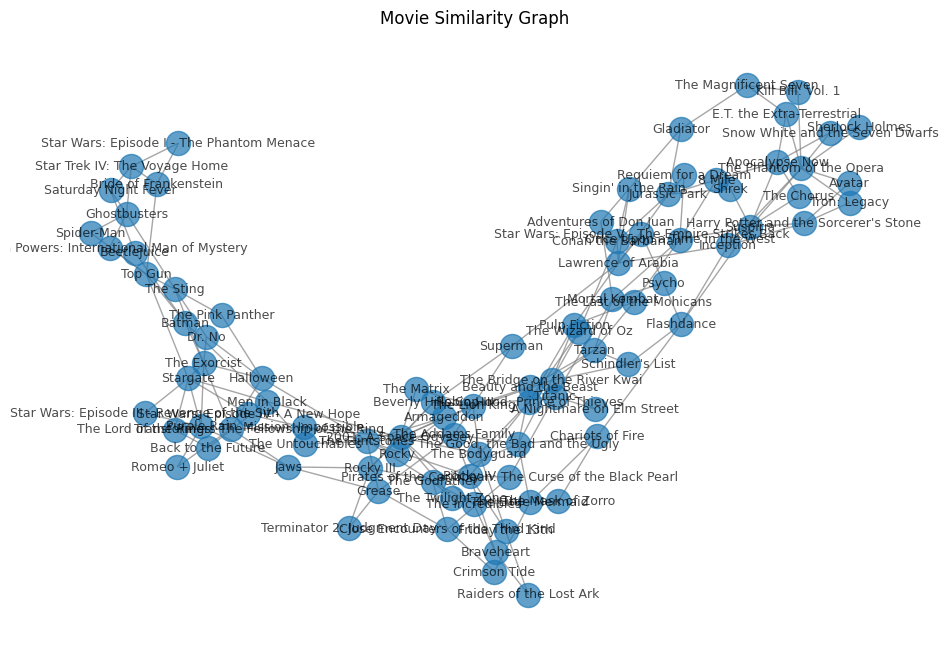

In [6]:
threshold = np.percentile(frob_matrix[np.triu_indices_from(frob_matrix, 1)], 75)
graph.plot_graph_networkx(frob_matrix, k=2, threshold=threshold, layout="spring")

**Recall:** For small $k$ (e.g. 2, 3), only the very closest neighbors are connected. Can create many disconnected components.

### Exploring the data

In [7]:
import numpy as np

def top_similar_movies_list(adjacency_matrix, nodes, top_k=10):
    """
    Returns a list of the top_k most similar movie pairs (shortest Frobenius distance).
    
    Args:
        adjacency_matrix (np.ndarray): Frobenius distance matrix.
        nodes (list): List of MovieNode objects.
        top_k (int): Number of top pairs to return.
    
    Returns:
        list of tuples: [(movie1_title, movie2_title, distance), ...]
    """
    n = adjacency_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)  # upper triangle indices
    all_pairs = [(i, j, adjacency_matrix[i, j]) for i, j in zip(*triu_idx)]
    all_pairs.sort(key=lambda x: x[2], reverse=False)  # smallest distance = most similar
    top_pairs = all_pairs[:top_k]
    
    return [(nodes[i].title, nodes[j].title, dist) for i, j, dist in top_pairs]

# Usage example:
top_10 = top_similar_movies_list(frob_matrix, graph.nodes, top_k=10)
for m1, m2, dist in top_10:
    print(f"{m1} <-> {m2}: distance={dist:.2f}")


Kill Bill: Vol. 1 <-> Avatar: distance=3.32
Kill Bill: Vol. 1 <-> Sherlock Holmes: distance=3.40
E.T. the Extra-Terrestrial <-> Sherlock Holmes: distance=3.42
Avatar <-> Sherlock Holmes: distance=3.46
E.T. the Extra-Terrestrial <-> Kill Bill: Vol. 1: distance=3.50
Kill Bill: Vol. 1 <-> Tron: Legacy: distance=3.54
E.T. the Extra-Terrestrial <-> Avatar: distance=3.55
Snow White and the Seven Dwarfs <-> Kill Bill: Vol. 1: distance=3.57
Avatar <-> Tron: Legacy: distance=3.61
The Magnificent Seven <-> Sherlock Holmes: distance=3.61


Star Wars: Episode I - The Phantom Menace: distance to mean = 5.22
Bride of Frankenstein: distance to mean = 5.05
Star Trek IV: The Voyage Home: distance to mean = 4.87
Ghostbusters: distance to mean = 4.82
Top Gun: distance to mean = 4.80
Austin Powers: International Man of Mystery: distance to mean = 4.78
Saturday Night Fever: distance to mean = 4.78
The Sting: distance to mean = 4.76
Dr. No: distance to mean = 4.75
The Exorcist: distance to mean = 4.71


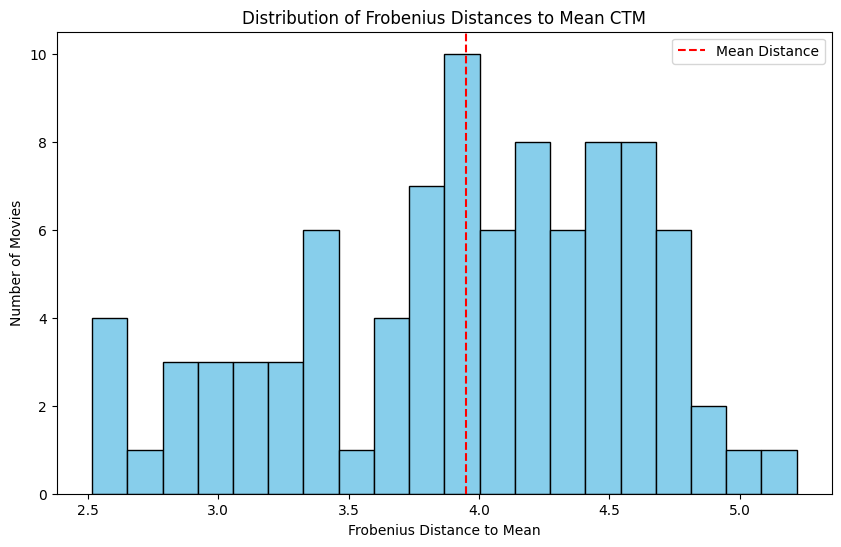

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def top_outlier_movies(ctms, nodes, top_k=10):
    """
    Returns the top_k most "outlier" movies by Frobenius distance to the mean CTM.

    Args:
        ctms (list of np.ndarray): List of chord trajectory matrices (CTMs).
        nodes (list): List of MovieNode objects.
        top_k (int): Number of top outliers to return.

    Returns:
        list of tuples: [(movie_title, distance_to_mean), ...]
    """
    # Compute the average CTM
    mean_ctm = np.mean(np.stack(ctms), axis=0)

    # Compute distance of each CTM to the mean
    distances = []
    for i, ctm in enumerate(ctms):
        diff = ctm - mean_ctm
        frob_dist = np.sqrt(np.sum(diff**2))  # Frobenius norm
        distances.append((nodes[i].title, frob_dist))

    # Sort by distance descending (most “outlier” first)
    distances.sort(key=lambda x: x[1], reverse=True)

    return distances[:top_k]

# Usage example
top_outliers = top_outlier_movies(
    list(matrices_df['matrix']),  # <-- use matrices_df instead of undefined `matrices`
    graph.nodes, 
    top_k=10
)

for title, dist in top_outliers:
    print(f"{title}: distance to mean = {dist:.2f}")

# Extract distances from top_outliers
distances = [dist for _, dist in top_outliers]

# Or if you want for all movies:
all_distances = [np.sqrt(np.sum((ctm - np.mean(np.stack(list(matrices_df['matrix'])), axis=0))**2))
                 for ctm in matrices_df['matrix']]

plt.figure(figsize=(10, 6))
plt.hist(all_distances, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Frobenius Distances to Mean CTM")
plt.xlabel("Frobenius Distance to Mean")
plt.ylabel("Number of Movies")
plt.axvline(np.mean(all_distances), color='red', linestyle='dashed', label='Mean Distance')
plt.legend()
plt.show()

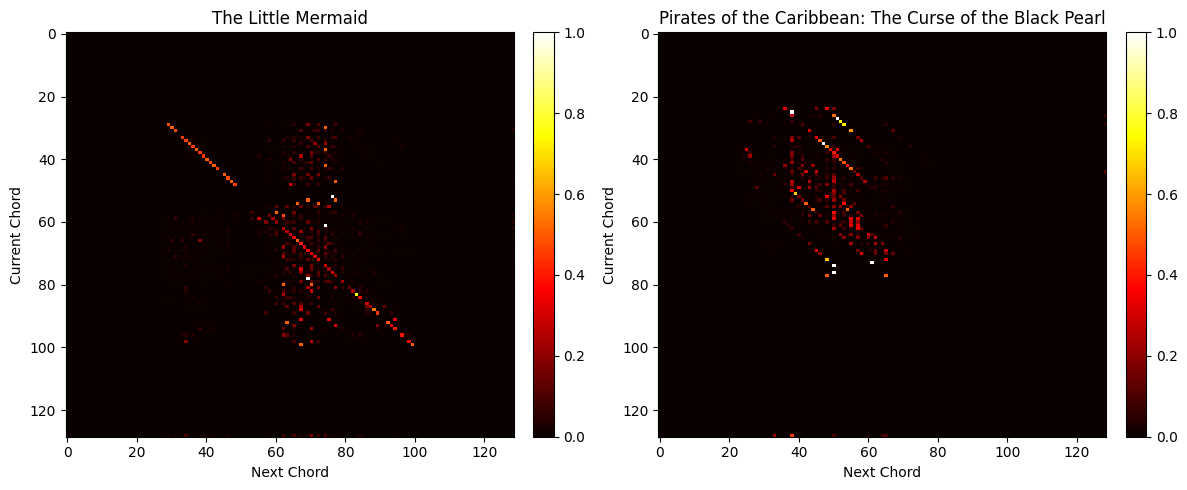

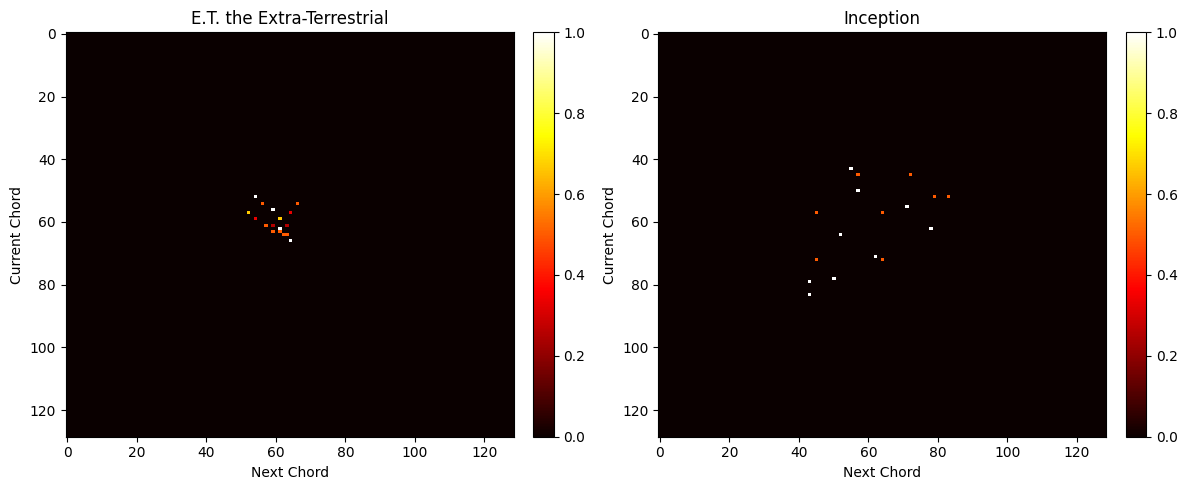

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ctms_side_by_side(matrices_df, metadata_df, titles=None, n_random=4):
    """
    Plot several CTMs side by side for visual comparison.
    
    Args:
        matrices_df (pd.DataFrame): DataFrame with 'matrix' column.
        metadata_df (pd.DataFrame): DataFrame with 'title' column matching matrices_df.
        titles (list[str] | None): List of movie titles to plot. If None, random movies are plotted.
        n_random (int): Number of random movies if titles is None.
    """
    if titles is None:
        random_indices = np.random.choice(matrices_df.shape[0], size=n_random, replace=False)
        matrices_to_plot = matrices_df.iloc[random_indices]
        titles = metadata_df.iloc[random_indices]['title'].tolist()
    else:
        matrices_to_plot = matrices_df.loc[metadata_df['title'].isin(titles)]

    n_plots = len(matrices_to_plot)
    n_cols = min(2, n_plots)
    n_rows = (n_plots + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

    for ax, (_, row), title in zip(axes, matrices_to_plot.iterrows(), titles):
        matrix = row['matrix']
        im = ax.imshow(matrix, cmap='hot', aspect='auto', interpolation='nearest')
        ax.set_title(title)
        ax.set_xlabel("Next Chord")
        ax.set_ylabel("Current Chord")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # hide unused axes
    for ax in axes[n_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Compare two chosen movies
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["The Little Mermaid", "Pirates of the Caribbean: The Curse of the Black Pearl"])
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["E.T. the Extra-Terrestrial", "Inception"])